In [1]:
MAKE_BOOK_FIGURES=False
import numpy as np
import scipy.stats as st

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

def set_book_style():
    plt.style.use('seaborn-v0_8-white') 
    sns.set_style("ticks")
    sns.set_palette("deep")

    mpl.rcParams.update({
        # Font settings
        'font.family': 'serif',  # For academic publishing
        'font.size': 8,  # As requested, 10pt font
        'axes.labelsize': 8,
        'axes.titlesize': 8,
        'xtick.labelsize': 7,  # Slightly smaller for better readability
        'ytick.labelsize': 7,
        'legend.fontsize': 7,
        
        # Line and marker settings for consistency
        'axes.linewidth': 0.5,
        'grid.linewidth': 0.5,
        'lines.linewidth': 1.0,
        'lines.markersize': 4,
        
        # Layout to prevent clipped labels
        'figure.constrained_layout.use': True,
        
        # Default DPI (will override when saving)
        'figure.dpi': 600,
        'savefig.dpi': 600,
        
        # Despine - remove top and right spines
        'axes.spines.top': False,
        'axes.spines.right': False,
        
        # Remove legend frame
        'legend.frameon': False,
        
        # Additional trim settings
        'figure.autolayout': True,  # Alternative to constrained_layout
        'savefig.bbox': 'tight',    # Trim when saving
        'savefig.pad_inches': 0.1   # Small padding to ensure nothing gets cut off
    })

def set_notebook_style():
    plt.style.use('seaborn-v0_8-white')
    sns.set_style("ticks")
    sns.set_palette("deep")

    mpl.rcParams.update({
        # Font settings - using default sizes
        'font.family': 'serif',
        'axes.labelsize': 10,
        'axes.titlesize': 10,
        'xtick.labelsize': 9,
        'ytick.labelsize': 9,
        'legend.fontsize': 9,
        
        # Line and marker settings
        'axes.linewidth': 0.5,
        'grid.linewidth': 0.5,
        'lines.linewidth': 1.0,
        'lines.markersize': 4,
        
        # Layout settings
        'figure.constrained_layout.use': True,
        
        # Remove only top and right spines
        'axes.spines.top': False,
        'axes.spines.right': False,
        
        # Remove legend frame
        'legend.frameon': False,
        
        # Additional settings
        'figure.autolayout': True,
        'savefig.bbox': 'tight',
        'savefig.pad_inches': 0.1
    })

def save_for_book(fig, filename, is_vector=True, **kwargs):
    """
    Save a figure with book-optimized settings.
    
    Parameters:
    -----------
    fig : matplotlib figure
        The figure to save
    filename : str
        Filename without extension
    is_vector : bool
        If True, saves as vector at 1000 dpi. If False, saves as raster at 600 dpi.
    **kwargs : dict
        Additional kwargs to pass to savefig
    """    
    # Set appropriate DPI and format based on figure type
    if is_vector:
        dpi = 1000
        ext = '.pdf'
    else:
        dpi = 600
        ext = '.tif'
    
    # Save the figure with book settings
    fig.savefig(f"{filename}{ext}", dpi=dpi, **kwargs)

def make_full_width_fig():
    return plt.subplots(figsize=(4.7, 2.9), constrained_layout=True)

def make_half_width_fig():
    return plt.subplots(figsize=(2.35, 1.45), constrained_layout=True)

if MAKE_BOOK_FIGURES:
    set_book_style()
else:
    set_notebook_style()

make_full_width_fig = make_full_width_fig if MAKE_BOOK_FIGURES else lambda: plt.subplots()
make_half_width_fig = make_half_width_fig if MAKE_BOOK_FIGURES else lambda: plt.subplots()

# Example: Priors on function spaces

## Gaussian process code

We will use the [GPyTorch](https://gpytorch.ai/) library to implement Gaussian processes. This library is built on top of PyTorch, which is a popular library for deep learning. We will learn more about PyTorch as we go and we will be more elaborate about it in [Lecture 24](regression-with-deep-neural-networks). The main purpose of PyTorch is to help us with automatic differentiation. For now, think of it as an alternative to numpy that allows us to compute gradients of functions.

In [2]:
!pip install gpytorch

## Squared exponential covariance function

Squared exponential (SE) is the most commonly used covariance function.
Its formula is as follows:

$$
k(\mathbf{x}, \mathbf{x}') = v\exp\left\{-\frac{1}{2}\sum_{i=1}^d\frac{(x_i - x_i')^2}{\ell_i^2}\right\},
$$

where $v,\ell_i>0, i=1,\dots,d$ are parameters.
The interpretation of the parameters is as follows:

+ $v$ is known as the *signal strength*. The bigger it is, the more the GP $f(\cdot)$ will vary
about the mean.

+ $\ell_i$ is known as the *length scale* of the $i$-th input dimension of the GP.
The bigger it is, the smoother the samples of $f(\cdot)$ appear along the $i$-th input dimension.

GPytorch implements this covariance function as a composition of two kernels: `RBFKernel` and `ScaleKernel`.
The `RBFKernel` is the squared exponential kernel (without the $v$), and the `ScaleKernel` is the kernel that scales the output of the `RBFKernel` by a constant factor (i.e., the $v$).
Here is how:

In [3]:
import torch
import gpytorch
from gpytorch.kernels import RBFKernel, ScaleKernel

# The input dimension
dim = 1
# The variance of the covariance kernel
variance = 1.
# The lengthscale of the covariance kernel
ell = 0.3
# Generate the covariance object
k = ScaleKernel(
        RBFKernel()
)
k.base_kernel.lengthscale = ell 
k.outputscale = variance
# Print it
k

ScaleKernel(
  (base_kernel): RBFKernel(
    (raw_lengthscale_constraint): Positive()
  )
  (raw_outputscale_constraint): Positive()
)

And here is how you can plot this covariance function when you set one input to zero:

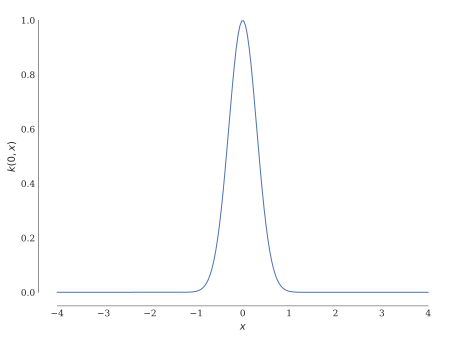

In [4]:
fig, ax = plt.subplots()
# Plot the covariance function
x = torch.linspace(-4, 4, 200)[:, None]
zero = torch.zeros(1)[:, None]
ks = k.forward(zero, x)
ax.plot(x, ks.detach().T)
ax.set_xlabel('$x$')
ax.set_ylabel('$k(0,x)$')
sns.despine(trim=True);

## Example 1: Plotting a covariance function
Remember:
> The covariance function $k(x,x')$ measures the similarity of $f(x)$ and $f(x')$.

Let's organize the plotting code in a function so that you can experiment with different parameters:

In [5]:
def plot_kernel(variance=1., ell=0.3):
    """Plot the covariance function."""
    k = ScaleKernel(
        RBFKernel()
    )
    k.base_kernel.lengthscale = ell
    k.outputscale = variance
    fig, ax = plt.subplots()
    x = torch.linspace(-4, 4, 200)[:, None]
    zero = torch.zeros(1)[:, None]
    ks = k.forward(zero, x)
    ax.plot(x, ks.detach().T)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$k(0,x)$')
    ax.set_ylim([0, 4])
    sns.despine(trim=True);

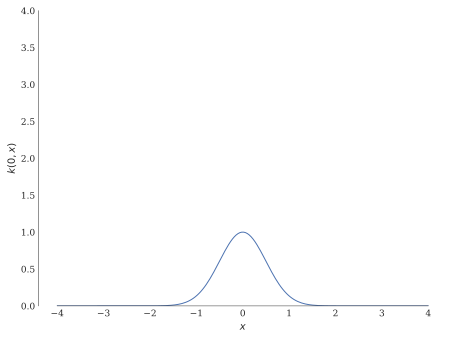

In [6]:
plot_kernel(variance=1.0, ell=0.5)

### Questions
+ What happens as you increase $\ell$?
+ What happens as you decrease $v$?
+ There are many other covariance functions that we could be using. Use the following code to compare the `RBFKernel` with the `MaternKernel`. What do you observe?

In [7]:
from gpytorch.kernels import MaternKernel

def compare_kernels(variance=1., ell=0.3, nu=0.5):
    """Compare the RBF and Matern kernels."""
    k1 = ScaleKernel(
        RBFKernel()
    )
    k1.base_kernel.lengthscale = ell
    k1.outputscale = variance
    k2 = ScaleKernel(
        MaternKernel(nu=nu)
    )
    k2.base_kernel.lengthscale = torch.tensor(ell)
    k2.outputscale = torch.tensor(variance)
    fig, ax = plt.subplots()
    x = torch.linspace(-4, 4, 500)[:, None]
    zero = torch.zeros(1)[:, None]
    ks1 = k1.forward(zero, x)
    ks2 = k2.forward(zero, x)
    ax.plot(x, ks1.detach().T, label='RBF') 
    ax.plot(x, ks2.detach().T, label='Matern $\\nu={}$'.format(nu))
    ax.set_xlabel('$x$')
    ax.set_ylabel('$k(0,x)$')
    ax.set_ylim([0, 4])
    plt.legend(loc='best', frameon=False)
    sns.despine(trim=True);

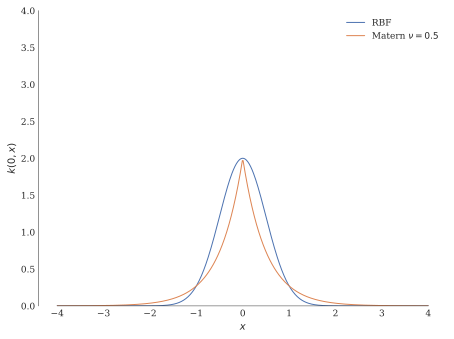

In [8]:
# Try the values 0.5, 1.5, 2.5 for nu (the only valid values)
compare_kernels(variance=2.0, ell=0.5, nu=0.5)

## Example 2: Plot 2D covariance function

Now here is some code to plot a 2D covariance function:

In [11]:
def plot_kernel_2d(variance=1., ell1=0.3, ell2=0.3):
    """Plot a 2D covariance function."""
    k = ScaleKernel(
        RBFKernel(ard_num_dims=2)
    )
    k.base_kernel.lengthscale = torch.tensor([ell1, ell2])
    k.outputscale = variance
    fig, ax = plt.subplots()
    # Get a grid of points
    x1 = torch.linspace(-2, 2, 100)
    x2 = torch.linspace(-2, 2, 100)
    x1, x2 = torch.meshgrid(x1, x2, indexing='ij')
    # Flatten the grid
    x = torch.cat((x1.flatten()[:, None], x2.flatten()[:, None]), dim=1)
    # Compute the covariance
    zero = torch.zeros(1, 2)
    ks = k.forward(zero, x)
    # Plot the covariance
    c = ax.contour(x1, x2, ks.detach().reshape(100, 100).T)
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    plt.colorbar(c, ax=ax)
    sns.despine(trim=True);

You can use it like this:

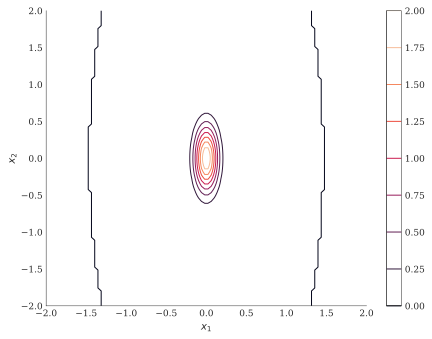

In [12]:
plot_kernel_2d(variance=2.0, ell1=0.3, ell2=0.1)

### Questions
+ What happens as you increase $\ell$?
+ What happens as you decrease $v$?
+ Edit the code above to replace the `RBFKernel` with the `MaternKernel`. What do you observe?

## Example 3: Properties of the covariance matrix
Let $\mathbf{x}_{1:n}$ be an arbitrary set of input points. The covariance matrix $\mathbf{K}\in\mathbb{R}^{n\times n}$ defined by:

$$
\mathbf{K}\equiv\mathbf{K}(\mathbf{x}_{1:n}, \mathbf{x}_{1:n}) = \left(
\begin{array}{ccc}
k(\mathbf{x}_1,\mathbf{x}_1) & \dots & k(\mathbf{x}_1, \mathbf{x}_n)\\
\vdots & \ddots & \vdots\\
k(\mathbf{x}_n, \mathbf{x}_1) & \dots & k(\mathbf{x}_n, \mathbf{x}_n)
\end{array}
\right),
$$

must be [positive definite](https://en.wikipedia.org/wiki/Positive-definite_matrix). Mathematically, this can be expressed in two equivalent ways:

+ For all vectors $\mathbf{v}\in\mathbb{R}^T$, we have:

$$
\mathbf{v}^t\mathbf{K}\mathbf{v} > 0,
$$

+ All the eigenvalues of $\mathbf{K}$ are positive.

### Questions
Using the code provided:
+ Verify that the sum of two covariance functions is a positive definite.
+ Verify that the product of two covariance functions is positive-definite.
+ Is the following function a covariance function:

$$
k(x, x') = k_1(x, x')k_2(x, x') + k_3(x, x') + k_4(x, x'),
$$

where all $k_i(x, x')$'s are covariance functions.
+ What about:

$$
k(x, x') = k_1(x, x') / k_2(x, x')?
$$

> plotting eigenvalues of K
> they must all be positive


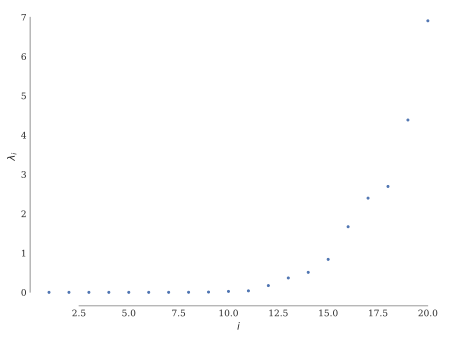

In [14]:
# Number of dimensions
dim = 1

# Number of input points
n = 20

# The lengthscale
ell = .1

# The variance 
variance = 1.

# The covariance function
k1 = ScaleKernel(
        RBFKernel()
    )
k1.base_kernel.lengthscale = ell
k1.outputscale = variance

# Draw a random set of inputs points in [0, 1]^dim
X = torch.rand(n, dim)

# Evaluate the covariance matrix on these points
K = k1.forward(X, X)

# Compute the eigenvalues of this matrix
eig_val, eig_vec = torch.linalg.eigh(K)

# Plot the eigenvalues (they should all be positive)
print ('> plotting eigenvalues of K')
print ('> they must all be positive')

fig, ax = plt.subplots()
ax.plot(np.arange(1, n+1), eig_val.detach(), '.')
ax.set_xlabel('$i$')
ax.set_ylabel(r'$\lambda_i$')
sns.despine(trim=True);

Now create another covariance function:

In [15]:
k2 = ScaleKernel(
        RBFKernel()
    )
k2.base_kernel.lengthscale = ell
k2.outputscale = 1.5

Create a new covariance function that is the sum of $k_1$ and $k_2$:

In [16]:
k_new = k1 + k2

Here is how the new covariance function looks like:

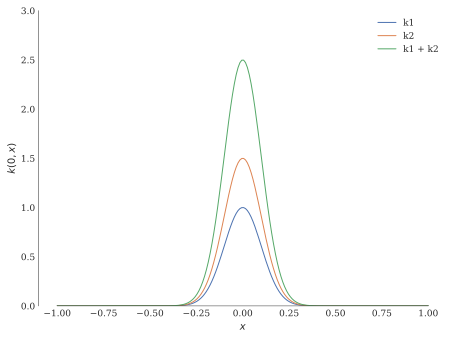

In [17]:
fig, ax = plt.subplots()
x = torch.linspace(-1, 1, 200)[:, None]
zero = torch.zeros(1)[:, None]
ks1 = k1.forward(zero, x)
ks2 = k2.forward(zero, x)
ks_new = k_new.forward(zero, x)
ax.plot(x, ks1.detach().T, label='k1')
ax.plot(x, ks2.detach().T, label='k2')
ax.plot(x, ks_new.detach().numpy().T, label='k1 + k2')
ax.set_xlabel('$x$')
ax.set_ylabel('$k(0,x)$')
ax.set_ylim([0, 3])
plt.legend(loc='best', frameon=False)
sns.despine(trim=True);

If this is a valid covariance function, then it must be positive-definite.
Let's test it:

<>:6: SyntaxWarning: invalid escape sequence '\l'
<>:6: SyntaxWarning: invalid escape sequence '\l'
/var/folders/3n/r5vj11ss7lzcdl10vfhb_mw00000gs/T/ipykernel_14263/340980877.py:6: SyntaxWarning: invalid escape sequence '\l'
  ax.set_ylabel('$\lambda_i$')


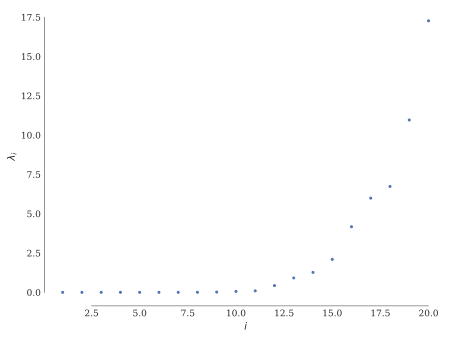

In [18]:
K_new = k_new.forward(X, X)
eig_val, eig_vec = torch.linalg.eigh(K_new)
fig, ax = plt.subplots()
ax.plot(np.arange(1, n+1), eig_val.detach(), '.')
ax.set_xlabel('$i$')
ax.set_ylabel('$\lambda_i$')
sns.despine(trim=True);

## Example 4: Sampling from a Gaussian process

Samples from a Gaussian process are functions. But functions are infinite-dimensional objects?
We cannot sample directly from a GP.
However, if we are interested in the values of $f(\cdot)$ at any given set of test points $\mathbf{x}_{1:n} = \{\mathbf{x}_1,\dots,\mathbf{x}_b\}$, then we have that:

$$
\mathbf{f} | \mathbf{x}_{1:n} \sim \mathcal{N}\left(\mathbf{m}(\mathbf{x}_{1:n}), \mathbf{K}(\mathbf{x}_{1:n}, \mathbf{x}_{1:n}) \right),
$$

where all the quantities have been introduced above.
What we are going to do is pick a dense set of points $\mathbf{x}_{1:n}\in\mathbb{R}^{n\times d}$
sample the value of the GP, $\mathbf{f} = (f(\mathbf{x}_1),\dots,f(\mathbf{x}_n))$ on these points.
We saw above that the probability density of $\mathbf{f}$ is just a multivariate normal
with a mean vector that is specified from the mean function and a covariance matrix
that is specified by the covariance function.
Therefore, we only need to know how to sample from the multivariate normal.
This is how we do it:
+ Compute the Cholesky of $\mathbf{L}$:

$$
\mathbf{K} = \mathbf{L}\mathbf{L}^T.
$$

+ Draw $n$ random samples $\mathbf{z} = (z_1,\dots,z_n)$ independently from a standard normal.
+ Get one sample by:

$$
\mathbf{f} = \mathbf{m} + \mathbf{L}\mathbf{z}.
$$

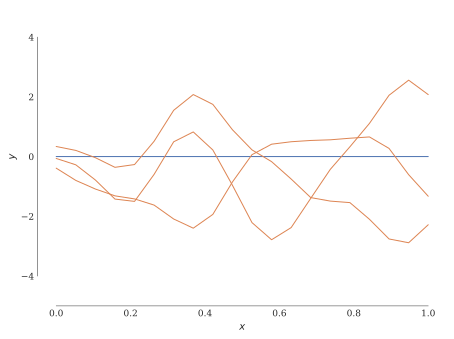

In [19]:
from gpytorch.means import ConstantMean, LinearMean

# To ensure reproducibility of the experiments
torch.manual_seed(123)

# Number of test points
num_test = 20

# Pick a covariance function
k = ScaleKernel(
        RBFKernel()
    )
k.base_kernel.lengthscale = 0.1
k.outputscale = 1.0

# Pick a mean function
mean_func = ConstantMean()

# Pick a bunch of points over which you want to sample the GP
X = torch.linspace(0, 1, num_test)[:, None]

# Evaluate the mean function at X
m = mean_func(X)

# Compute the covariance function at these points
nugget = 1e-5 # This is a small number required for stability
C = k.forward(X, X) + nugget * torch.eye(X.shape[0])

# Compute the Cholesky of the covariance
# Notice that we need to do this only once
L = torch.linalg.cholesky(C)

# Number of samples to take
num_samples = 3

# Take 3 samples from the GP and plot them:
fig, ax = plt.subplots()
# Plot the mean function
ax.plot(X, m.detach())
for i in range(num_samples):
    z = torch.randn(X.shape[0], 1)  
    f = m[:, None] + L @ z               
    ax.plot(X, f.detach(), color=sns.color_palette()[1], linewidth=1)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_ylim(-5, 5)
sns.despine(trim=True);

The solid line is the mean function, and the dashed lines are three f samples. These do not look like functions yet. This is because we have used only 10 test points to represent the GP.

### Questions

+ Edit the code above changing the number of test points ``num_test`` to 20, 50, 100. Rerun the example. What do your samples of f look like now? Do they look more like functions to you? Imagine that the true nature of the GP appears when these test points become infinitely dense.

+ Edit the code above and change the random seed to an arbitrary integer (makeup one). Rerun the example and notice how the sampled functions change.

### Controlling the lengthscale of the sampled functions

Let's put all the code above in a function so that we can experiment with different parameters:

In [20]:
def sample_functions(mean_func, kernel_func, num_samples=10, num_test=100, nugget=1e-5):
    """Sample functions from a Gaussian process.

    Arguments:
        mean_func -- the mean function. It must be a callable that takes a tensor
            of shape (num_test, dim) and returns a tensor of shape (num_test, 1).
        kernel_func -- the covariance function. It must be a callable that takes
            a tensor of shape (num_test, dim) and returns a tensor of shape
            (num_test, num_test).
        num_samples -- the number of samples to take. Defaults to 10.
        num_test -- the number of test points. Defaults to 100.
        nugget -- a small number required for stability. Defaults to 1e-5.
    """
    X = torch.linspace(0, 1, num_test)[:, None]
    m = mean_func(X)
    C = k.forward(X, X) + nugget * torch.eye(X.shape[0])
    L = torch.linalg.cholesky(C)
    fig, ax = plt.subplots()
    ax.plot(X, m.detach(), label='mean')
    for i in range(num_samples):
        z = torch.randn(X.shape[0], 1) 
        f = m[:, None] + L @ z  
        ax.plot(X.flatten(), f.detach().flatten(), color=sns.color_palette()[1], linewidth=0.5, 
                label='sample' if i == 0 else None
            )
    plt.legend(loc='best', frameon=False)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_ylim(-5, 5)
    sns.despine(trim=True);

Here is how to use it:

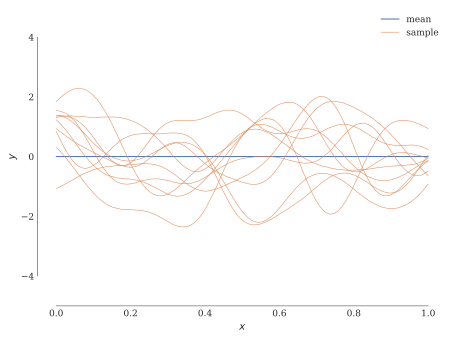

In [21]:
mean_func = ConstantMean()
k = ScaleKernel(
        RBFKernel()
    )
k.base_kernel.lengthscale = torch.tensor(0.1)
k.outputscale = torch.tensor(1.0)
sample_functions(mean_func, k)


### Questions

+ Use the code above and change the variance to 0.1 and then to 3 each time rerunning the example. Notice the values on the vertical axis of the plot. What happens to the sampled functions as you do this? What is the variance parameter of the SE control?

+ Edit the above code and change the lengthscale parameter to 0.05 and 1. What happens to the sampled functions as you do this? 

### Controlling the trend of the sampled functions

We control the trend using the mean function. Let's do a linear mean function:

$$
m(x) = ax + b.
$$

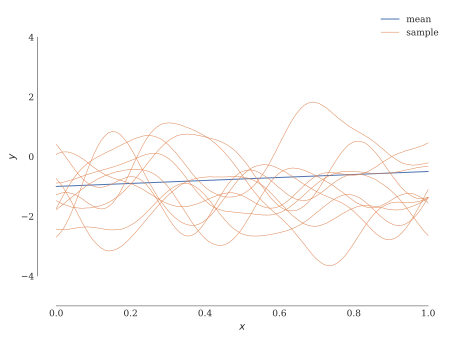

In [22]:
a = 0.5
b = -1.0
mean_func = LinearMean(input_size=1)
mean_func.weights = torch.nn.Parameter(torch.tensor([a]))
mean_func.bias = torch.nn.Parameter(torch.tensor([b]))
k = ScaleKernel(
        RBFKernel()
    )
k.base_kernel.lengthscale = 0.1
k.outputscale = 1.0
sample_functions(mean_func, k)

### Questions

+ Modify the code above to set the mean function to:
```
     mean_fun = lambda(x): 5 * x
```

### Using a mean function not in the GPytorch library

Let's use a mean function that is not in the GPytorch library. We will the mean function:

$$
    m(x) = a\sin(\omega x),
$$

where $a$ and $\omega$ are parameters.
We need to inherit from the ``gpytorch.means.Mean`` class and implement the ``forward`` method:

In [23]:
class MyMean(torch.nn.Module):
    """A custom mean function."""
    def __init__(self, batch_shape=torch.Size()):
        super().__init__()
        self.register_parameter("a", torch.nn.Parameter(torch.randn(*batch_shape, 1)))
        self.register_parameter("omega", torch.nn.Parameter(torch.randn(*batch_shape, 1)))
    def forward(self, x):
        return self.a * torch.sin(self.omega * x).squeeze(-1)

Let's use it:

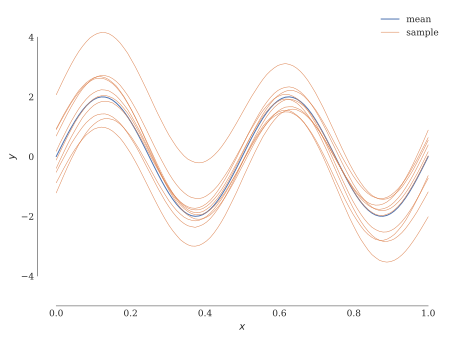

In [24]:
a = 2.0
omega = 2.0 * np.pi * 2.0
mean_func = MyMean()
mean_func.a = torch.nn.Parameter(torch.tensor([a]))
mean_func.omega = torch.nn.Parameter(torch.tensor([omega]))
k = ScaleKernel(
        RBFKernel()
    )
k.base_kernel.lengthscale = 0.5
k.outputscale = 1.0
sample_functions(mean_func, k)

### Questions

+ Experiment with different values of the lengthscale and variance parameters.
+ Modify the code above to model an exponential decay trend:

$$
    m(x) = a\exp(-\omega x).
$$

### The smoothness of the sampled functions is controlled by the smoothness of the covariance function

The smoothness of the function is the number of times it is continuously differentiable.
There is a theorem that says that the smoothness of the sampled functions is controlled by the smoothness of the covariance function {cite:p}`10.7551/mitpress/3206.001.0001`.
The covariance function that we have been using so far is the squared exponential (SE) covariance function.
The SE covariance function is infinitely differentiable.
So, the sampled functions are infinitely differentiable.

Let's look at the samples of a function that is not infinitely differentiable.
We will use the Matérn covariance function:

$$
k(x, x') = \frac{2^{1-\nu}}{\Gamma(\nu)}\left(\sqrt{2\nu}\frac{|x-x'|}{\ell}\right)^\nu K_\nu\left(\sqrt{2\nu}\frac{|x-x'|}{\ell}\right),
$$

where $\Gamma(\cdot)$ is the gamma function, $K_\nu(\cdot)$ is the modified Bessel function of the second kind, $\nu>0$ is a parameter, and $\ell>0$ is the lengthscale parameter.
Samples from the Matérn covariance function are $\text{ceil}(\nu)-1$ times differentiable, where $\text{ceil}(\cdot)$ is the ceiling function.
For example if $\nu=1.5$, then the samples are $\text{ceil}(1.5)-1=2 - 1 = 1$ times differentiable.

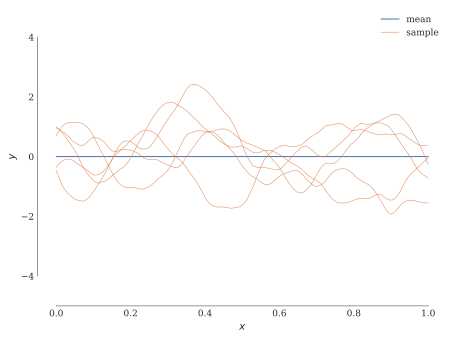

In [25]:
mean_func = ConstantMean()
k = ScaleKernel(
        MaternKernel(nu=2.5)
    )
k.base_kernel.lengthscale = 0.1
k.outputscale = 1.0
sample_functions(mean_func, k, num_samples=5, num_test=200)

### Questions

+ Experiment with different values $\nu = 1.5$ and $\nu=0.5$.
+ For $\nu=0.5$ you get continuous but nowhere differentiable samples. To appreciate this, set the number of samples to 1 and increase the number of test points to 1000. If you go through the trouble of modifying the plotting code to zoom in a small region of the plot, you will see that the samples are self-similar. You have just discovered a fractal!

## Example 5: Modeling invariances

The covariance function can also be used to model invariances.
It is better to explain this with an example.

One common invariance is translation invariance:

$$
f(x + \delta) = f(x), \quad \forall x\in\mathbb{R}, \delta\in\mathbb{R}.
$$

One can show that if the covariance function is translation invariant, then samples are also translation invariant.
An example of a translation invariant covariance function is the `PeriodicKernel`:

$$
k(x, x') = \exp\left\{-\frac{2}{\ell}\sin^2\left(\frac{\pi}{p}|x-x'|\right)\right\},
$$

where $v,\ell>0$ are parameters and $p>0$ is the period parameter (the $\delta$ above).
Let's look at the samples:

PeriodicKernel(
  (raw_lengthscale_constraint): Positive()
  (raw_period_length_constraint): Positive()
)


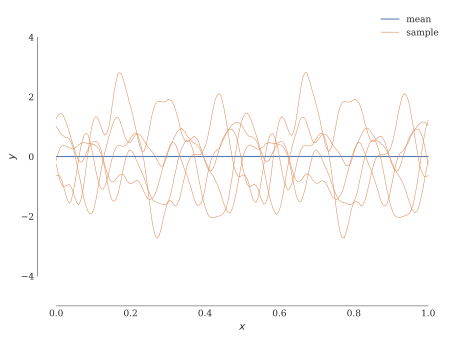

In [28]:
from gpytorch.kernels import PeriodicKernel
mean_func = ConstantMean()
k = ScaleKernel(
        PeriodicKernel()
    )
print(k.base_kernel)
k.base_kernel.period_length = 0.5
k.base_kernel.lengthscale = 0.1
k.outputscale = 1.0
sample_functions(mean_func, k, num_samples=5, num_test=200, nugget=1e-4)

### Questions

+ Experiment with different values of the period parameter $p$ and the lengthscale parameter $\ell$. Note that at some point you will get an error because the covariance matrix will become singular. You will have to increase the nugget parameter to overcome this.

### Stationary and non-stationary covariance functions

So far we have only used stationary covariance functions.
A covariance function is stationary if it depends only on the distance between the inputs:

$$
k(x, x') = k(|x-x'|).
$$

This means that the samples from that covariance function look similar everywhere.

Sometimes, we want to model functions that are not behaving in a similar manner for all inputs.
For example, they may have more wiggles in some parts of the input space than others.
A classic non-stationary covariance function is the `LinearKernel`:

$$
k(x, x') = vxx',
$$

where $v>0$ is a variance parameter.

Let's look at the samples:

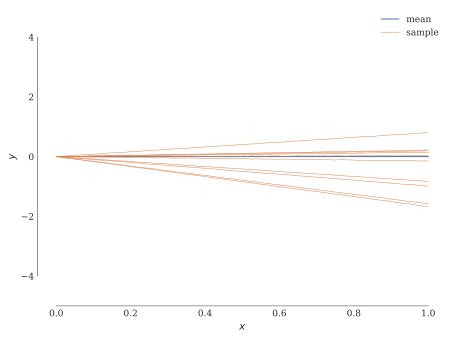

In [29]:
from gpytorch.kernels import LinearKernel

mean_func = ConstantMean()
k = LinearKernel()
k.outputscale = 1.0
sample_functions(mean_func, k)

They are lines starting from the origin.

Another classic non-stationary covariance function is the `PolynomialKernel`:

$$
k(x, x') = (x^Tx' + c)^d,
$$

where $c$ is an offset parameter and $d$ is a degree parameter.

Let's visualize the samples:

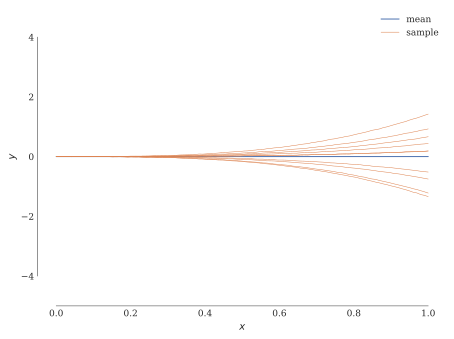

In [30]:
from gpytorch.kernels import PolynomialKernel

mean_func = ConstantMean()
k = ScaleKernel(PolynomialKernel(power=3))
k.base_kernel.offset = 0.0
k.outputscale = 1.0
sample_functions(mean_func, k)

### Questions

+ Experiment with different values of the offsets and degrees.

### Two (or more) length scales in samples

Suppose that we have a function that is the sum of two functions: one that varies slowly and one that varies quickly.
How can we model this?
We need to use two covariance functions: one with a small lengthscale and one with a large lengthscale.
Then we need to add the two covariance functions together.
Let's see how this works.

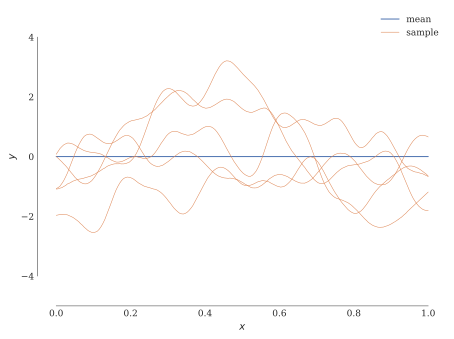

In [31]:
mean_func = ConstantMean()
kslow = ScaleKernel(RBFKernel())
kslow.base_kernel.lengthscale = 0.3
kslow.outputscale = 1.0
kfast = ScaleKernel(RBFKernel())
kfast.base_kernel.lengthscale = 0.05
kfast.outputscale = 0.4
k = kslow + kfast
sample_functions(mean_func, k, num_samples=5, num_test=200)

### Questions

+ Modify the code above to look at the product of two covariance functions.
+ Modify the code to model a slowly varying periodic function contaminated by an additive noise coming from a Matérn covariance function that is nowhere differentiable.